# Filipe Borba e Martim José

#### Como escolher o melhor DJ para a festa de fim do semestre?

Proposta: 
- Carregar os grafos one-mode e two-mode construídos hoje;
- Calcular indegree do one-mode;
- Calcular hub/authority do two-mode;
- Calcular uma terceira métrica, proposta pela dupla;
- Fazer testes de hipótese pertinentes sobre essas métricas.


## Etapa 1: Carregar os grafos e fazer os cálculos

A ideia dessa etapa é utilizar os dados passados e construir os grafos one-mode e two-mode. O grafo one-mode é o tradicional, nós que se comunicam e qualquer uma das arestas pode existir, direcionadas ou não (no caso são direcionadas por envolver recomendação). Já o grafo two-mode possui dois tipos de nó, associado a dois grupos distintos: pessoas e gêneros. Nele, só existem arestas unidirecionais. No caso, de pessoas para gêneros.

A partir disso, calcula-se o indegree e outdegree de cada nó, ou seja, quantas vezes foi indicado e quantas vezes indicou. E com eles calcula-se os valores de hub e authority da rede two mode. 
Authority estima a força do nó baseado no indegree, enquanto que Hub estima o valor do nó baseado no outdegree.

In [1]:
import sys
sys.path.append('..')

from random import choice
import pandas as pd
import scipy
import numpy as np
from itertools import permutations
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import socnet as sn

In [2]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'top center'

In [3]:
g = sn.load_graph('one-mode.gml', has_pos=False)

In [4]:
w = sn.load_graph('two-mode.gml', has_pos=False)

In [5]:
def set_indegree(g):
    for n in g.nodes:
        g.nodes[n]['indegree'] = g.in_degree(n)
        
def set_out_degree(g):
    for n in g.nodes:
        g.nodes[n]['outdegree'] = g.out_degree(n)

In [6]:
def outdegree_ponderado(g):
    for n in g.nodes:
        node = g.nodes[n]
        if node['indegree'] == 0: #É uma pessoa
            soma = 0
            for j in range(len(list(g.successors(n)))):
                soma += g.nodes[list(g.successors(n))[j]]["indegree"]
            node["hub"] = soma
        else:
            node["hub"] = 0
    return g

def indegree_ponderado(g):
    for n in g.nodes:
        node = g.nodes[n]
        if node['outdegree'] == 0: #É um genero
            soma = 0
            for j in range(len(list(g.predecessors(n)))):
                soma += g.nodes[list(g.predecessors(n))[j]]["hub"]
            node["auth"] = soma
        else:
            node["auth"] = 0
    return g

def indegree_ponderado_normalizado(g):
    soma_total = 0
    for n in g.nodes:
        if g.nodes[n]["indegree"] == 0:
            soma_total += g.nodes[n]["hub"]
        
    for n in g.nodes:
        if g.nodes[n]["indegree"] == 0:
            g.nodes[n]["hub"] = g.nodes[n]["hub"]/soma_total
    return g
        
def outdegree_ponderado_normalizado(g):
    soma_total = 0
    for n in g.nodes:
        if g.nodes[n]['outdegree'] == 0:
            soma_total += g.nodes[n]["auth"]
        
    for n in g.nodes:
        if g.nodes[n]['outdegree'] == 0:
            g.nodes[n]["auth"] = g.nodes[n]["auth"]/soma_total
    return g

def euclidian_distance(g1, g2):
    hub = sum([((g1.nodes[n]["hub"] - g2.nodes[n]["hub"])**2) for n in g.nodes])**0.5
    print(hub)
    auth = sum([(g1.nodes[i]["auth"] - g2.nodes[i]["auth"])** 2 for i in range(len(g1.nodes))]) ** 0.5
    return hub
    
def set_hub_authority(g):
    set_indegree(g)
    set_out_degree(g)
    g = outdegree_ponderado(g)
    g = indegree_ponderado(g)
    g = indegree_ponderado_normalizado(g)
    g = outdegree_ponderado_normalizado(g)
    return g

def converge(g):
    g = set_hub_authority(g)
    delta = 1
    epsilon = 10**-7
    while delta > epsilon:
        g1 = g.copy()
        g = set_hub_authority(g)
        delta = euclidian_distance(g1, g)
    return g

## Etapa 2: Terceira métrica e análise

Dadas as métricas de hub e authority dos nós, tivemos de propor uma nova métrica. Escolhemos então a métrica de PageRank para grafos. PageRank é um algoritmo que mede a importância de uma página contabilizando a quantidade e qualidade de links apontando para ela. Esse algoritmo pode ser implementado para o nosso contexto de forma que as páginas são os gêneros e a qualidade da indicação para DJ é variável de acordo com quantas indicações eles recebem.

In [7]:
converge(w)
pr2 = nx.pagerank(w, alpha=0.9)

0.0


In [8]:
twomode = pd.DataFrame({
    'nome': [w.nodes[n]['label'] for n in w.nodes],
    'outdegree': [w.nodes[n]['outdegree'] for n in w.nodes],
    'indegree': [w.nodes[n]['indegree'] for n in w.nodes],
    'hub': [w.nodes[n]['hub'] for n in w.nodes],
    'auth': [w.nodes[n]['auth'] for n in w.nodes],
    'pageranks': [pr2[n] for n in pr2]
})

In [9]:
twomode[twomode.indegree != 0].iloc[:, [0,2,4]].sort_values(by="auth", ascending=False)

,nome,indegree,auth
24,Eletronica,19,0.128628
32,Rock classico,11,0.079566
25,Pop Rock,11,0.078085
5,Pop,11,0.075025
31,Pagode,10,0.072655
4,Rap Nacional,10,0.068806
17,Indie Rock,8,0.063672
26,Disco,8,0.063376
19,Funk,9,0.058243
22,Sertanejo,8,0.057947


In [10]:
twomode[twomode.outdegree != 0].iloc[:, [0,1,3]].sort_values(by="hub", ascending=False)

,nome,outdegree,hub
12,Forba,15,0.091625
34,Jean,10,0.068003
23,Sabrina,10,0.067287
21,Toyama,8,0.059413
20,Rachel,7,0.055834
16,Vitoria,7,0.052971
13,Hugo,7,0.051539
1,Isa,7,0.050823
33,Joao,6,0.047960
39,Graicer,6,0.046528


In [11]:
twomode[twomode.indegree != 0].iloc[:, [0,5]].sort_values(by="pageranks", ascending=False)

,nome,pageranks
24,Eletronica,0.065738
5,Pop,0.049658
25,Pop Rock,0.046922
37,J-Pop,0.042933
32,Rock classico,0.042192
4,Rap Nacional,0.041450
31,Pagode,0.038662
19,Funk,0.038644
22,Sertanejo,0.034549
15,Metal,0.034037


### Análise dataframes
A partir das análises dos dataframes, podemos ter uma primeira visão da resposta da nossa hipótese. Forba, Jean e Sabrina possuem maior outdegree, portanto maior valor de Hub. Assim, são fortes candidatos para serem os DJs da festa por gostarem de mais gêneros. Apesar disso, estamos analisando a rede two-mode, então, os pesos de recomendação entre as pessoas não é levado em consideração, afetando diretamente nossa conclusão.
Secundariamente, é possível verificar que os gêneros "Eletronica", "Pop" e "Pop Rock" são os mais populares entre o grupo, sendo aumentando a credibilidade dos DJs que os escolheram.

## Etapa 3: Testes de Hipótese

In [12]:
hub_list = []
for i in w.nodes:
    value = w.nodes[i]["hub"]
    hub_list.append(value)

auth_list = []
for i in w.nodes:
    value = w.nodes[i]["auth"]
    auth_list.append(value)
    
pr_list = list(pr2.values())

In [34]:
from scipy.stats import linregress

def get_indegree_list(g):
    indegree_list = []
    for e in g.nodes:
        value = g.nodes[e]["indegree"]
        indegree_list.append(value)
    return indegree_list

def get_outdegree_list(g):
    outdegree_list = []
    for e in g.nodes:
        value = g.nodes[e]["outdegree"]
        outdegree_list.append(value)
    return outdegree_list

indegree_list = get_indegree_list(w)
outdegree_list = get_outdegree_list(w)

l = linregress(hub_list, pr_list)
print("Hub x PageRank")
print("Correlação:", l.rvalue, "\n", "P-Value:", round(l.pvalue, 5),"\n")

l = linregress(auth_list, pr_list)
print("Auth x PageRank")
print("Correlação:", l.rvalue, "\n", "P-Value:", round(l.pvalue, 5),"\n")

Hub x PageRank
Correlação: -0.6741303141 
 P-Value: 0.0 

Auth x PageRank
Correlação: 0.971822357931 
 P-Value: 0.0 



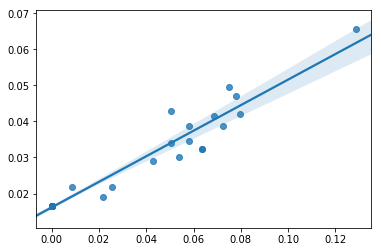

In [21]:
sns.regplot(x=auth_list, y=pr_list)

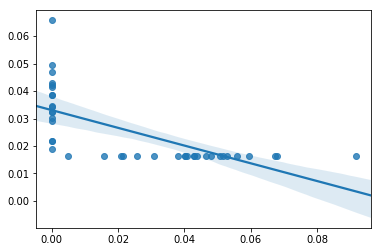

In [22]:
sns.regplot(x=hub_list, y=pr_list)

### Análise regressões lineares
Fazendo a regressão linear utilizando o Pagerank como variável dependente e ora Auth ora Hub como variável dependente, obtivemos um p-valor menor que 0.00. Além disso, a correlação entre Auth e Pagerank é positiva e extremamente forte, enquanto que Hub tem uma relação moderada e negativa com o Pagerank.
Portanto, a partir das análises, concluímos que o Pagerank é uma boa métrica para ser utilizada, pois leva tanto Hub quanto Authority em consideração para fazer o cálculo, trazendo uma visão mais real da rede do que apenas as duas variáveis separadas.

# Rede One Mode

### Temos os melhores gêneros. Qual será o melhor DJ?

In [18]:
hubs, auth = nx.hits(g)
set_indegree(g)
set_out_degree(g)
pr = nx.pagerank(g, alpha=0.9)

In [19]:
pd.DataFrame({
    'nome': [g.nodes[n]['label'] for n in g.nodes],
    'indegree': [g.nodes[n]['indegree'] for n in g.nodes],
    'outdegree': [g.nodes[n]['outdegree'] for n in g.nodes],
    'hub': [hubs[n] for n in hubs],
    'auth': [auth[n] for n in auth],
    'pageranks': [pr[n] for n in pr]
}).sort_values(by=["pageranks", "hub"], ascending=False)

,nome,indegree,outdegree,hub,auth,pageranks
10,Hugo,12,3,0.038989,0.135274,0.183554
18,Graicer,10,2,0.034679,0.125647,0.105987
15,Forba,7,7,0.102443,0.100104,0.098895
7,Fred,7,4,0.056536,0.096399,0.095981
22,Isa,3,2,0.035588,0.040415,0.076960
0,Rachel,5,4,0.047178,0.078124,0.068358
8,Toyama,7,2,0.036157,0.109203,0.063825
12,Elisa,2,1,0.002895,0.018846,0.058707
23,Chen,6,3,0.027634,0.036790,0.055260
9,Vitoria,5,4,0.013276,0.039265,0.027585


### Conclusão

A partir da rede one-mode ordenada pelos maiores Pageranks e as conclusões da rede two-mode, concluímos que a melhor escolha de DJ para a festa seria o Forba, uma vez que ele está presente no topo nos dois dataframes criados. Apesar disso, o Hugo não deixa de ser uma boa opção, dados os seus valores the Pagerank, Hub e Authority.